In [1]:
from ANEMO import ANEMO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.10'

In [2]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [3]:
from edfreader import read_edf
datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [4]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [5]:
def fct_exponentiel (x, bino, start_anti, v_anti, latence, tau, maxi) : # RENOMMER !!!
    v_anti = v_anti/1000 # pour passer de sec à ms
    time = x # np.arange(len(x))
    vitesse = []

    for t in range(len(time)):

        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence))))
        else :
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    #vitesse.append((bino*2-1)*(time[t]-start_anti)*v_anti)
                    vitesse.append((time[t]-start_anti)*v_anti)
                    y = (time[t]-start_anti)*v_anti
                else :
                    m = maxi # (maxi-y*(bino*2-1))
                    #vitesse.append((bino*2-1)*(maxi-y*(bino*2-1)*(-1))*(1-np.exp(-1/tau*(time[t]-latence)))+y)
                    vitesse.append((bino*2-1)*(m)*(1-np.exp(-1/tau*(time[t]-latence)))+y)
    return vitesse

In [6]:
def Microsaccade (velocity_x, velocity_y, VFAC=5, mindur=5, maxdur=100, minsep=30, trackertime_0=0):

    msdx = np.sqrt((np.nanmedian(velocity_x**2))-((np.nanmedian(velocity_x))**2))
    msdy = np.sqrt((np.nanmedian(velocity_y**2))-((np.nanmedian(velocity_y))**2))

    radiusx = VFAC*msdx
    radiusy = VFAC*msdy

    test = (velocity_x/radiusx)**2 + (velocity_y/radiusy)**2
    index = [x for x in range(len(test)) if test[x] > 1]

    dur = 0
    debut_misaccades = 0
    k = 0
    misaccades = []

    for i in range(len(index)-1) :
        if index[i+1]-index[i]==1 :
            dur = dur + 1;
        else :
            if dur >= mindur and dur < maxdur :
                fin_misaccades = i
                misaccades.append([index[debut_misaccades]+trackertime_0, index[fin_misaccades]+trackertime_0])
            debut_misaccades = i+1
            dur = 1
        i = i + 1

    if len(misaccades) > 1 :
        s=0
        while s < len(misaccades)-1 :
            sep = misaccades[s+1][0]-misaccades[s][1] # temporal separation between onset of saccade s+1 and offset of saccade s
            if sep < minsep :
                misaccades[s][1] = misaccades[s+1][1] #the two saccades are fused into one
                del(misaccades[s+1])
                s=s-1
            s=s+1

    s=0
    while s < len(misaccades) :
        dur = misaccades[s][1]-misaccades[s][0] # duration of sth saccade
        if dur >= maxdur :
            del(misaccades[s])
            s=s-1
        s=s+1  

    return misaccades


In [7]:
def suppression_saccades(velocity, saccades, trackertime, avant=5, apres=15) :


    trackertime_0 = trackertime[0]

    for s in range(len(saccades)) :
        if saccades[s][1]-trackertime_0+apres <= (len(trackertime)) :
            for x_data in np.arange((saccades[s][0]-trackertime_0-avant), (saccades[s][1]-trackertime_0+apres)) :
                velocity[x_data] = np.nan
        else :
            for x_data in np.arange((saccades[s][0]-trackertime_0-avant), (len(trackertime))) :
                velocity[x_data] = np.nan

    return velocity


In [8]:
def FIT(data, x, tau, maxi, latence, start_anti, v_anti, bino):
    
    model = Model(fct_exponentiel)
    params = Parameters()

    params.add('tau', value=tau[0], min=tau[1], max=tau[2])
    params.add('maxi', value=maxi[0], min=maxi[1], max=maxi[2])
    params.add('latence', value=latence[0], min=latence[1], max=latence[2])
    params.add('start_anti', value=start_anti[0], min=start_anti[1], max=start_anti[2])
    params.add('v_anti', value=v_anti[0], min=v_anti[1], max=v_anti[2])
    params.add('bino', value=bino, vary=False)

    result_deg = model.fit(data, params, x=x, nan_policy='omit')
    
    return result_deg

In [13]:
def plot(data, num_plot=0, nb=25) :

    if num_plot==0 :
        fig, axs = plt.subplots(3, 2, figsize=(5*2, (5*3)/1.6180))

    if num_plot==1 :
        fig, axs = plt.subplots(1, 2, figsize=(5*2, (5*1)/1.6180))
    
    if num_plot==2 :
        fig, axs = plt.subplots(nb, 1, figsize=(15, nb*(15*1/2)/1.6180))


    for trial_data in range(nb) :

        if trial_data < 200 :
            block = 0
        elif trial_data < 400 :
            block = 1
        else :
            block = 2

        trial = trial_data - N_trials*block #trial_data = trial + N_trials*block

        data_x = data[trial_data]['x']
        data_y = data[trial_data]['y']
        trackertime = data[trial_data]['trackertime']

        StimulusOn = data[trial_data]['events']['msg'][10][0]
        StimulusOf = data[trial_data]['events']['msg'][14][0]
        TargetOn = data[trial_data]['events']['msg'][15][0]
        TargetOff = data[trial_data]['events']['msg'][16][0]
        saccades = data[trial_data]['events']['Esac']
        trackertime_0 = data[trial_data]['trackertime'][0]
        bino = p[trial, block, 0]


        gradient_x = np.gradient(data_x) # gradient en px/ms
        gradientx_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec
        gradient_y = np.gradient(data_y)
        gradienty_deg = gradient_y * 1/exp['px_per_deg'] * 1000

        #-------------------------------------------------
        # SUPPRESSION DES SACCADES
        #-------------------------------------------------
        stop_recherche_misac = TargetOn-trackertime_0+100
        misac = ANEMO.Microsaccade(gradientx_deg[:stop_recherche_misac], gradienty_deg[:stop_recherche_misac],
                                   trackertime_0=trackertime_0)
        saccades.extend(misac)

        gradient_deg_NAN = ANEMO.suppression_saccades(gradientx_deg, saccades, trackertime)

        stop_latence = None   
        for s in range(len(saccades)) :
            if stop_latence != None and (saccades[s][0]-trackertime_0) >= (TargetOn-trackertime_0+100) :
                #stop_latence.append((saccades[s][0]-trackertime_0))
                stop_latence = saccades[s][0]-trackertime_0
        if stop_latence == None :
            stop_latence = len(trackertime)
        #-------------------------------------------------

        start = TargetOn
        StimulusOn_s = StimulusOn - start
        StimulusOf_s = StimulusOf - start
        TargetOn_s = TargetOn - start
        TargetOff_s = TargetOff - start
        trackertime_s = trackertime - start

        
        # FIT
        #-------------------------------------------------
        vitesse, x = gradient_deg_NAN[:-250], np.arange(len(trackertime[:-250]))
        tau_init = [15.,13.,80.]
        maxi_init = [15.,1.,40.]
        latence_init = [TargetOn-trackertime_0+100,TargetOn-trackertime_0+75,stop_latence]
        start_anti_init = [TargetOn-trackertime_0-100, StimulusOf-trackertime_0-200, TargetOn-trackertime_0-75]
        v_anti_init = [0.,-40.,40.]
        
        
        result_deg = FIT(vitesse, x, tau_init, maxi_init, latence_init, start_anti_init, v_anti_init, bino)
        start_anti = result_deg.values['start_anti']
        v_anti = result_deg.values['v_anti']
        latence = result_deg.values['latence']
        tau = result_deg.values['tau']
        maxi = result_deg.values['maxi']
        #-------------------------------------------------
        
        

        # FIT avec vieux paramètres
        #-----------------------------------------------------------------------------------------------------------
        """ /!\ vérifier si c'est bien ça """
        
        a, b = StimulusOn-trackertime_0, StimulusOf-trackertime_0
        c, seuil = TargetOn-trackertime_0+100, 3
        lat = np.where(np.abs(gradient_deg_NAN[c:]) > np.abs(np.nanmean(gradient_deg_NAN[a:b]))+np.abs(np.nanstd(gradient_deg_NAN[a:b])*seuil))
        old_latence = lat[0][0]+c
        
        a1, b1 = TargetOn-trackertime_0+400, TargetOn-trackertime_0+600
        maxmax = np.where(np.abs(gradient_deg_NAN) > np.abs(np.nanmean(gradient_deg_NAN[a1:b1])))
        old_max = np.abs(gradient_deg_NAN[maxmax[0][0]])
        
        maxi2_init = [old_max,1.,40.]
        latence2_init = [old_latence-100,TargetOn-trackertime_0+50,stop_latence]

        result_deg = FIT(vitesse, x, tau_init, maxi2_init, latence2_init, start_anti_init, v_anti_init, bino)
        start_anti2 = result_deg.values['start_anti']
        v_anti2 = result_deg.values['v_anti']
        latence2 = result_deg.values['latence']
        tau2 = result_deg.values['tau']
        maxi2 = result_deg.values['maxi']
        #-------------------------------------------------
        
        debut  = TargetOn - trackertime_0
        
        if num_plot==0 :
            axs[0][0].set_title('start_anti')
            axs[0][1].set_title('v_anti')
            axs[1][0].set_title('latence')
            axs[1][1].set_title('tau')
            axs[2][0].set_title('maxi')
            for a in range(3) :
                for b in range(2) :
                    axs[a][b].set_xlabel('1')
                    axs[a][b].set_ylabel('2')

            axs[0][0].scatter(start_anti-debut, start_anti2-debut , c='k', alpha=0.5)
            axs[0][1].scatter(v_anti, v_anti2 , c='k', alpha=0.5)
            axs[1][0].scatter(latence-debut, latence2-debut , c='k', alpha=0.5)
            axs[1][1].scatter(tau, tau2 , c='k', alpha=0.5)
            axs[2][0].scatter(maxi, maxi2 , c='k', alpha=0.5)

            plt.tight_layout() 

        if num_plot==1 :
            
            axs[0].set_title('latence')
            axs[1].set_title('maxi')
            for a in range(2) :
                axs[a].set_xlabel('old')
                axs[a].set_ylabel('new')
            
            axs[0].scatter(old_latence-debut, latence-debut, c='k', alpha=0.5)
            axs[1].scatter(old_max, maxi, c='k', alpha=0.5)

            plt.tight_layout() 
            
        if num_plot==2 :
            
            axs[trial_data].axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
            axs[trial_data].axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
            axs[trial_data].axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
            for s in range(len(saccades)) :
                axs[trial_data].axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

            axs[trial_data].axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])
            axs[trial_data].plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.6)
            
            init_fit = fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti_init[0], v_anti_init[0], latence_init[0], tau_init[0], maxi_init[0])
            best_fit = fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti, v_anti, latence, tau, maxi)
            axs[trial_data].plot(trackertime_s[:-250], init_fit, 'r--', linewidth=1)
            axs[trial_data].plot(trackertime_s[:-250], best_fit, color='r', linewidth=1)

            init_fit2 = fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti_init[0], v_anti_init[0], latence2_init[0], tau_init[0], maxi2_init[0])
            best_fit2 = fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti2, v_anti2, latence2, tau2, maxi2)
            axs[trial_data].plot(trackertime_s[:-250], init_fit2, 'g--', linewidth=1)
            axs[trial_data].plot(trackertime_s[:-250], best_fit2, color='g', linewidth=1)
            
            axs[trial_data].plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*old_max, color='k', alpha=0.2)
            axs[trial_data].bar(old_latence-debut, 80, bottom=-40, color='g', width=4, linewidth=0)

            axs[trial_data].text(StimulusOn_s+15, 18, "start_anti: %0.3f \nv_anti: %0.3f"%(start_anti-debut, v_anti), color='k', fontsize=14, va='bottom')
            axs[trial_data].text(StimulusOn_s+15, -18, "latence: %0.3f \nmaxi: %0.3f \ntau: %0.3f"%(latence-debut, maxi, tau), color='k', fontsize=14, va='top')
            axs[trial_data].text(StimulusOn_s+400, 18, "start_anti: %0.3f \nv_anti: %0.3f"%(start_anti2-debut, v_anti2), color='k', fontsize=14, va='bottom')
            axs[trial_data].text(StimulusOn_s+400, -18, "latence: %0.3f \nmaxi: %0.3f \ntau: %0.3f"%(latence2-debut, maxi2, tau2), color='k', fontsize=14, va='top')
            axs[trial_data].text(StimulusOn_s+800, -18, "lat: %0.3f \nmaximax: %0.3f"%(old_latence-debut, old_max), color='k', fontsize=14, va='top')

    plt.show()

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater


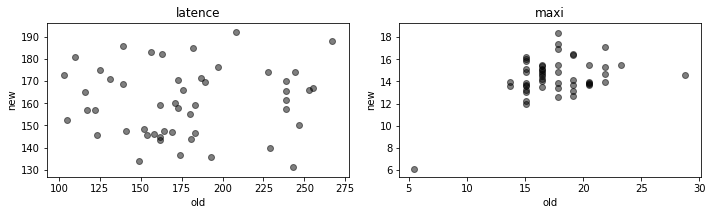

In [10]:
plot(data, num_plot=1, nb=50)

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater


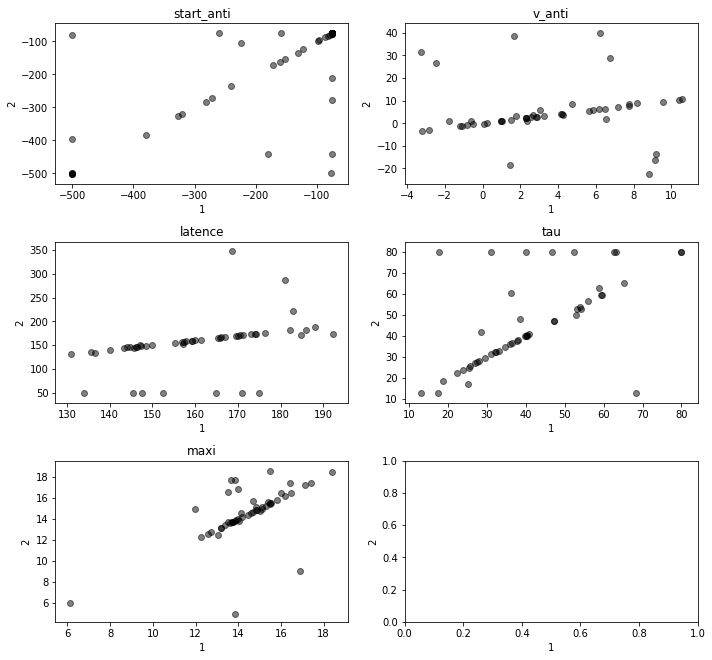

In [11]:
plot(data, num_plot=0, nb=50)

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater


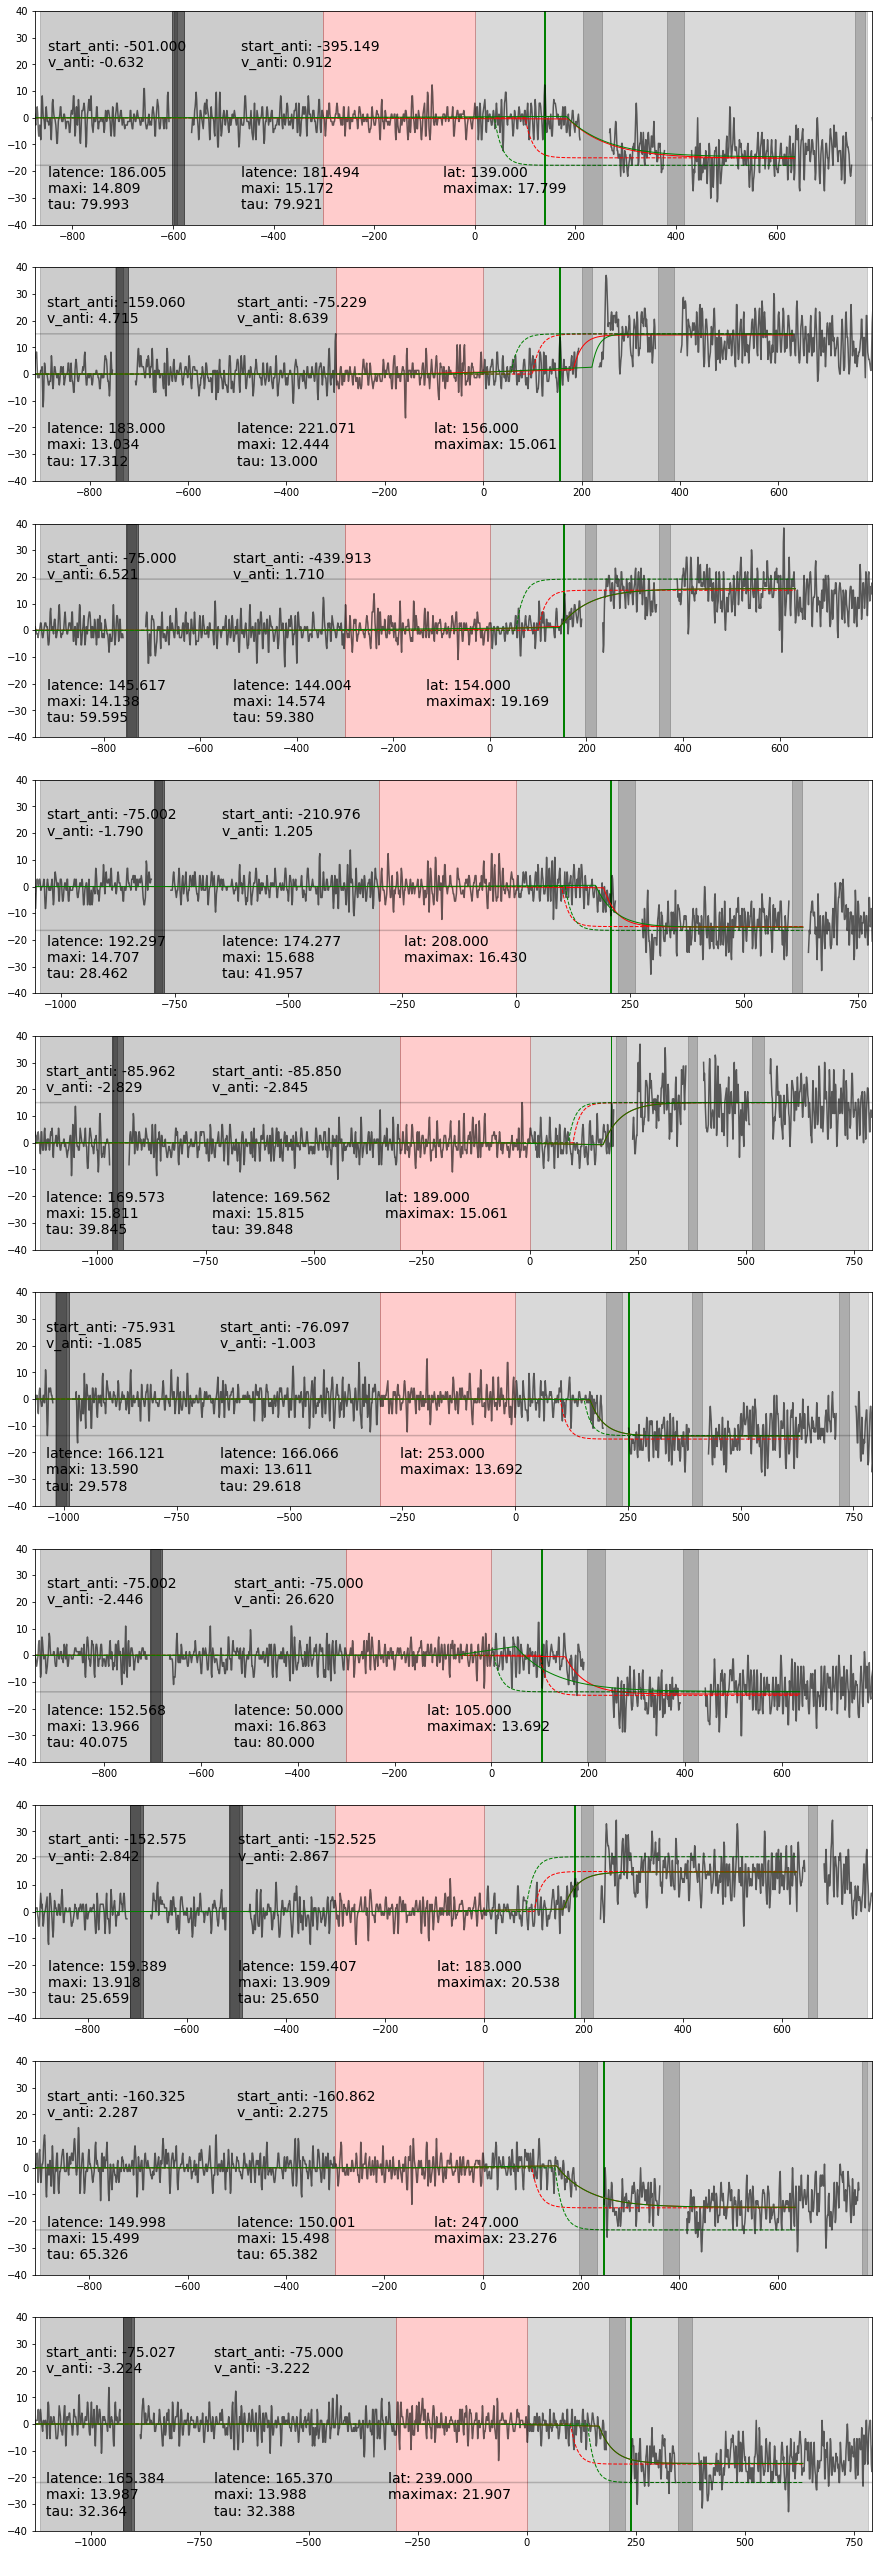

In [14]:
plot(data, num_plot=2, nb=10)